# Investigating linear solvers options on flow problem with random fractures

Import necessery packages:

In [1]:
import os

os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

import numpy as np
import porepy as pp
import FTHM_Solver
import scipy.stats as stats
from pprint import pprint


And few additional ones

In [2]:
import time
import pandas as pd
import copy
from joblib import Parallel, delayed, parallel_backend
import itertools
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt


This bit is from flow_setup.py

In [3]:
from porepy.examples.flow_benchmark_2d_case_4 import (
    FlowBenchmark2dCase4Model,
    solid_constants as solid_constants_2d,
)


class StochasticGeometry:
    def set_fractures(self):
        #np.random.seed(self.params.get("seed", 82))

        num_fractures = self.params.get("num_fractures", 10)

        # Generate random fracture orientations. For now, we assume uniform distribution
        # of orientations in the range [0, pi]. We may change this later.
        orientation_distr = stats.uniform(loc=0, scale=np.pi)
        orientation = orientation_distr.rvs(size=num_fractures)

        # Represent fracture lengths as a log-normal distribution. The parameters set
        # here are quite random.
        length_distr = stats.lognorm(s=1, scale=0.5)
        lengths = length_distr.rvs(size=num_fractures)

        # Generate random fracture centers. For now, we assume uniform distribution
        # of positions in the range [0, 1] in both x and y directions.
        position_distr = stats.uniform(loc=0, scale=1)
        positions_x = position_distr.rvs(size=num_fractures)
        positions_y = position_distr.rvs(size=num_fractures)

        # Create the endpoints of the fractures based on the lengths and orientations.
        endpoints = []
        for i in range(num_fractures):
            cx = positions_x[i]
            cy = positions_y[i]
            length = lengths[i]
            theta = orientation[i]

            x0 = cx - 0.5 * length * np.cos(theta)
            y0 = cy - 0.5 * length * np.sin(theta)

            p0 = np.array([x0, y0]).reshape((2, 1))

            x1 = cx + 0.5 * length * np.cos(theta)
            y1 = cy + 0.5 * length * np.sin(theta)
            p1 = np.array([x1, y1]).reshape((2, 1))

            endpoints.append(np.hstack([p0, p1]))

        # Create the fractures as line segments.
        fractures = []
        for point_pairs in endpoints:
            fractures.append(pp.LineFracture(point_pairs))

        # Set the fractures in the model.
        self._fractures = fractures

    def grid_type(self):
        return "simplex"


class Source:
    def fluid_source(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        domain = self.domain
        box = domain.bounding_box_from_polytope()

        x_mean = (box["xmax"] + box["xmin"]) / 2
        y_mean = (box["ymax"] + box["ymin"]) / 2

        src_ambient = np.zeros(
            sum(sd.num_cells for sd in subdomains if sd.dim == self.nd)
        )
        src_fracture = np.zeros(
            sum(sd.num_cells for sd in subdomains if sd.dim == self.nd - 1)
        )
        src_intersection = np.zeros(
            sum(sd.num_cells for sd in subdomains if sd.dim < self.nd - 1)
        )

        if len(self._fractures) == 0:
            # Domain without fractures. Put the source in the center of the domain.
            sd = subdomains[0]
            closest_cell = sd.closest_cell(
                np.array([x_mean, y_mean, 0]).reshape((3, 1))
            )
            src_ambient[closest_cell] = 1.0
        else:
            x, y, z = np.concatenate(
                [sd.cell_centers for sd in subdomains if sd.dim == self.nd - 1], axis=1
            )
            source_loc = np.argmin((x - x_mean) ** 2 + (y - y_mean) ** 2)
            src_fracture[source_loc] = 1

        return super().fluid_source(subdomains) + pp.ad.DenseArray(
            np.concatenate([src_ambient, src_fracture, src_intersection])
        )


class ModelProperties:
    def _is_nonlinear_problem(self) -> bool:
        """Check if the model is nonlinear."""
        return False


class StochasticModel(
    StochasticGeometry,
    FTHM_Solver.IterativeSolverMixin,
    Source,
    ModelProperties,
    pp.SinglePhaseFlow,
):
    pass


class BenchmarkModel(
    Source,
    FTHM_Solver.IterativeSolverMixin,
    ModelProperties,
    FlowBenchmark2dCase4Model,
):
    # We may want to look at this at some point, but for now, consider it untested and
    # optional.
    pass


if True:
    model_class = StochasticModel
else:
    model_class = BenchmarkModel


def reset_model_state(model):
    """Reset the model state to a clean state.

    This can be useful to run several simulations with the same model (discretization
    etc.) but, say, with different solver parameters.
    """
    mdg = model.mdg

    num_cells = sum(sd.num_cells for sd in mdg.subdomains())
    num_interface_cells = sum(intf.num_cells for intf in mdg.interfaces())

    zeros = np.zeros(num_cells + num_interface_cells, dtype=float)
    model.equation_system.set_variable_values(
        values=zeros, additive=False, time_step_index=0
    )
    model.equation_system.set_variable_values(
        values=zeros, additive=False, iterate_index=0
    )

    model.time_manager = pp.TimeManager(schedule=[0, 1], dt_init=1, constant_dt=True)

## Initialize the model 

In [4]:
model_params = {
    "solid_constants": solid_constants_2d,
    "linear_solver": {"preconditioner_factory": FTHM_Solver.mass_balance_factory},
    # Control the number of fractures here.
    "num_fractures": 50,
    # This is the simplest way to control the cell size. You can also do
    # 'cell_size_fracture' and 'cell_size_boundary'.
   # "meshing_arguments": {"cell_size": 0.2,
                          #"cell_size_min": 0.05,         # avoid too-small elements
                          #"cell_size_fracture": 0.1,    # fine mesh around fractures
                          #"cell_size_fracture_min": 0.0045,    # fine mesh around fractures
                          #"cell_size_boundary": 0.2      # coarser mesh at outer boundary
    #                     },
    # Control the name of the gmsh file here.
    "meshing_kwargs": {"file_name": "mesh_2d"}
}

In [ ]:
#import shutil

## Source: where the mesh is now (inside the container)
#src = "mesh_2d.msh"

## Destination: mounted folder that maps to D:\ML4pmg
#dst = "/host_output/Data/mesh_2d_50fr_MC.msh"

#shutil.copyfile(src, dst)

'/host_output/Data/mesh_2d_50fr_MC.msh'

In [5]:
model = model_class(model_params)
model.prepare_simulation()

In [14]:
model.mdg.subdomains

<bound method MixedDimensionalGrid.subdomains of Mixed-dimensional grid containing 267 grids and 482 interfaces.
Maximum dimension present: 2 
Minimum dimension present: 0 
1 grids of dimension 2 with in total 25264 cells
50 grids of dimension 1 with in total 3245 cells
216 grids of dimension 0 with in total 216 cells
50 interfaces between grids of dimension 2 and 1 with in total 6490 mortar cells.
432 interfaces between grids of dimension 1 and 0 with in total 864 mortar cells.
>

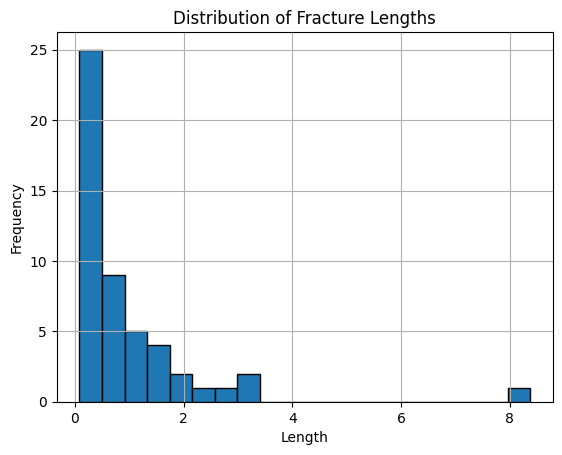


 Smallest fracture: 0.0833


In [15]:
# Compute actual lengths of the generated fractures
fractures = model.fractures
actual_lengths = [
    np.linalg.norm(frac.pts[:, 1] - frac.pts[:, 0])
    for frac in fractures
]

plt.hist(actual_lengths, bins=20, edgecolor='black')
plt.title("Distribution of Fracture Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Recommend cell size near fractures
min_length = min(actual_lengths)

print(f"\n Smallest fracture: {min_length:.4f}")

Define solvers and update model parameters

In [27]:

linear_solver_opts = {
    # This line PETSc print the residual norm at each iteration.
    #"ksp_monitor": None,
    #"ksp_view": None,
    "ksp_type": 'bcgs',#"preonly",#"tfqmr1",#"gmres1", #"richardson0", #"bicg0", #"bcgs1",  # Change the Krylov method
    "ksp_max_it": 150,
    "interface_darcy_flux": {"pc_type": "ilu"}, # fix this to ilu for now
    "mass_balance": {"pc_type": "lu"},
}

model.params["linear_solver"].update({"options": linear_solver_opts})



In [17]:
try:
    pp.run_time_dependent_model(model, {"prepare_simulation": False})
    pprint(f"Simulation completed successfully with {model._krylov_iters} iterations.")
except Exception as e:
        print(f"Solver failed!")
        print(f" Error: {e}")
    

'Simulation completed successfully with [5, 5] iterations.'


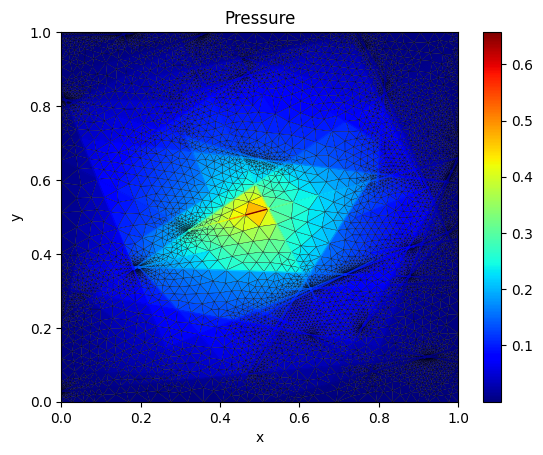

In [16]:
ifPlot =True
if ifPlot:
     pp.plot_grid(
        model.mdg,
        "pressure",
        figsize=(10, 8),
        linewidth=0.2,
        title='Pressure',
        plot_2d=True,
        )

In [18]:

print(f' Time for solving {model._solve_time}')
print(f' Number of Krylov iterations {model._krylov_iters}')

 Time for solving [0.09348225593566895, 0.08142781257629395]
 Number of Krylov iterations [5, 5]


In [19]:
import pickle
pickle.dumps(model)  # Raises error if model cannot be serialized


AttributeError: Can't get local object 'FluidMixin.specific_volume_of_phase.<locals>.volume'

## Running for different solvers

In [20]:
model._krylov_iters=[0]
model._solve_time=[0]
model._construction_time=[0]

In [21]:
# Define solver types and preconditioners
ksp_types = ["gmres", "bcgs", "tfqmr"]
preconditioners_mass = ["ilu", "lu", "sor", "jacobi", "bjacobi", "asm",  "gamg"]
preconditioners_interface = ["ilu", "lu", "sor"]

# Generate all combinations
solver_combinations = list(itertools.product(ksp_types, preconditioners_interface,preconditioners_mass))

# Store results
results = []

for idx, (ksp, pc_interface, pc_mass) in enumerate(solver_combinations):
    print(f"\n➡️ Running combination #{idx + 1}: {ksp} + {pc_mass} + {pc_interface}")
    
    reset_model_state(model)
    
    linear_solver_opts = {
        "ksp_type": ksp,
        "interface_darcy_flux": {"pc_type": pc_interface},
        "mass_balance": {"pc_type": pc_mass}
    }
   
    model.params["linear_solver"].update({"options": linear_solver_opts})
      
    try:
        start = time.time()
        pp.run_time_dependent_model(model, {"prepare_simulation": False})
        end = time.time()

        results.append({
            "Combination #": idx,
            "KSP Type": ksp,
            "PC Mass": pc_mass,
            "PC Interface": pc_interface,
            "Converged": True,
            "Krylov Iters": model._krylov_iters[-1],
            "Construction Time (s)": model._construction_time[-1],
            "Solve Time (s)": model._solve_time[-1],
            "Total Time (s)": model._construction_time[-1] + model._solve_time[-1],
            "Tic Toc Time (s)": end - start
            })
      
    except Exception as e:
        print(f"❌ Combination #{idx+1} failed: {ksp} + {pc_mass} + {pc_interface}")
        print(f"   ⚠️ Error: {type(e).__name__}: {e}")
        # print(f" Error: {e}")
        results.append({
            "Combination #": idx,
            "KSP Type": ksp,
            "PC Mass": pc_mass,
            "PC Interface": pc_interface,
            "Converged": False,
            "Krylov Iters": None,
            "Construction Time (s)": None,
            "Solve Time (s)": None,
            "Total Time (s)": None,
            "Tic Toc Time (s)": None
            })
    
# Convert results to DataFrame and save
df_results = pd.DataFrame(results)



➡️ Running combination #1: gmres + ilu + ilu
❌ Combination #1 failed: gmres + ilu + ilu
   ⚠️ Error: RuntimeError: Solver did not converge. Reason: -3. Check the solver options and the problem setup.

➡️ Running combination #2: gmres + lu + ilu

➡️ Running combination #3: gmres + sor + ilu
❌ Combination #3 failed: gmres + sor + ilu
   ⚠️ Error: RuntimeError: Solver did not converge. Reason: -3. Check the solver options and the problem setup.

➡️ Running combination #4: gmres + jacobi + ilu
❌ Combination #4 failed: gmres + jacobi + ilu
   ⚠️ Error: RuntimeError: Solver did not converge. Reason: -3. Check the solver options and the problem setup.

➡️ Running combination #5: gmres + bjacobi + ilu
❌ Combination #5 failed: gmres + bjacobi + ilu
   ⚠️ Error: RuntimeError: Solver did not converge. Reason: -3. Check the solver options and the problem setup.

➡️ Running combination #6: gmres + asm + ilu
❌ Combination #6 failed: gmres + asm + ilu
   ⚠️ Error: RuntimeError: Solver did not conver

In [87]:
df_results

,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s)
0,0,gmres,ilu,ilu,False,NaN,NaN,NaN,NaN,NaN
1,1,gmres,lu,ilu,True,7.0,0.989403,0.059638,1.049041,7.6619
2,2,gmres,sor,ilu,False,NaN,NaN,NaN,NaN,NaN
3,3,gmres,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN
4,4,gmres,bjacobi,ilu,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
58,58,tfqmr,sor,sor,False,NaN,NaN,NaN,NaN,NaN
59,59,tfqmr,jacobi,sor,False,NaN,NaN,NaN,NaN,NaN
60,60,tfqmr,bjacobi,sor,False,NaN,NaN,NaN,NaN,NaN
61,61,tfqmr,asm,sor,False,NaN,NaN,NaN,NaN,NaN


In [ ]:
#df_results.to_csv("/host_output/Data/ManySolver_Times.csv", index=False)

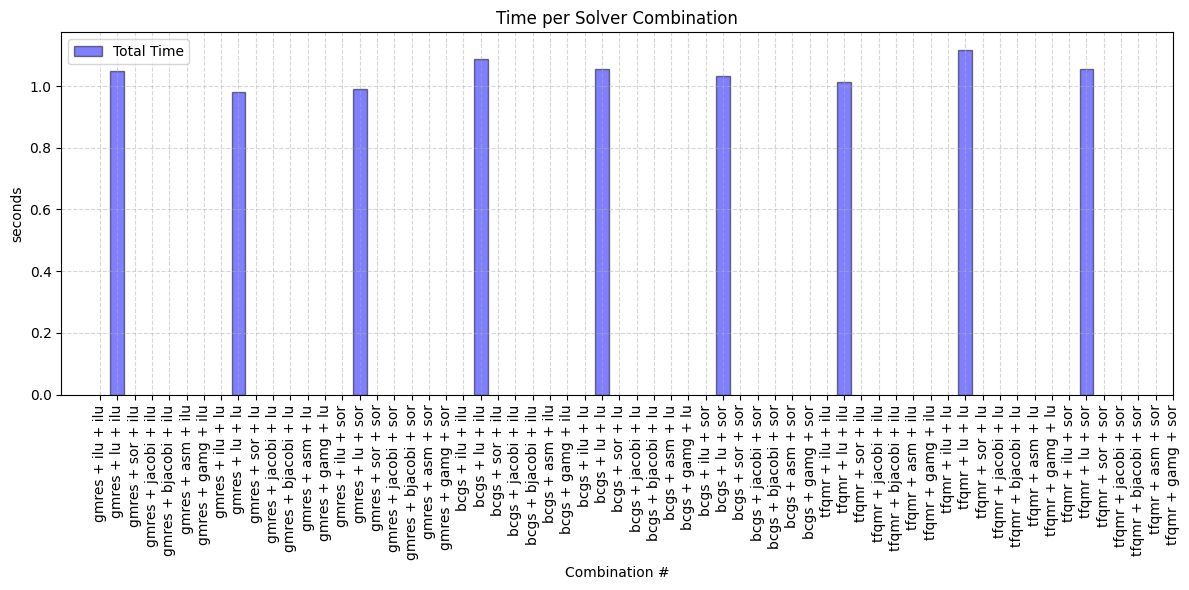

In [88]:
df_results["label"] = df_results["KSP Type"] + " + " + df_results["PC Mass"] + " + " + df_results["PC Interface"]
plt.figure(figsize=(12, 6))
plt.bar(df_results["Combination #"], df_results["Total Time (s)"], color="blue", edgecolor="k", alpha=0.5, label="Total Time")
#plt.bar(df_results["Combination #"], df_results["Tic Toc Time (s)"], color="pink", edgecolor="k", alpha=0.5,  label="Tic Toc Time")
#plt.bar(df_results2["Combination #"], df_results2["Time (s)"], color="yellow", edgecolor="k", alpha=0.5)

indices = np.arange(len(df_results["Combination #"]))
plt.xticks(indices, df_results["label"], rotation=90)
plt.xlabel("Combination #")
plt.ylabel("seconds")
plt.title("Time per Solver Combination")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_80742/4085150856.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flux_ilu["label"] = df_flux_ilu["KSP Type"] + " + " + df_flux_ilu["PC Mass"]


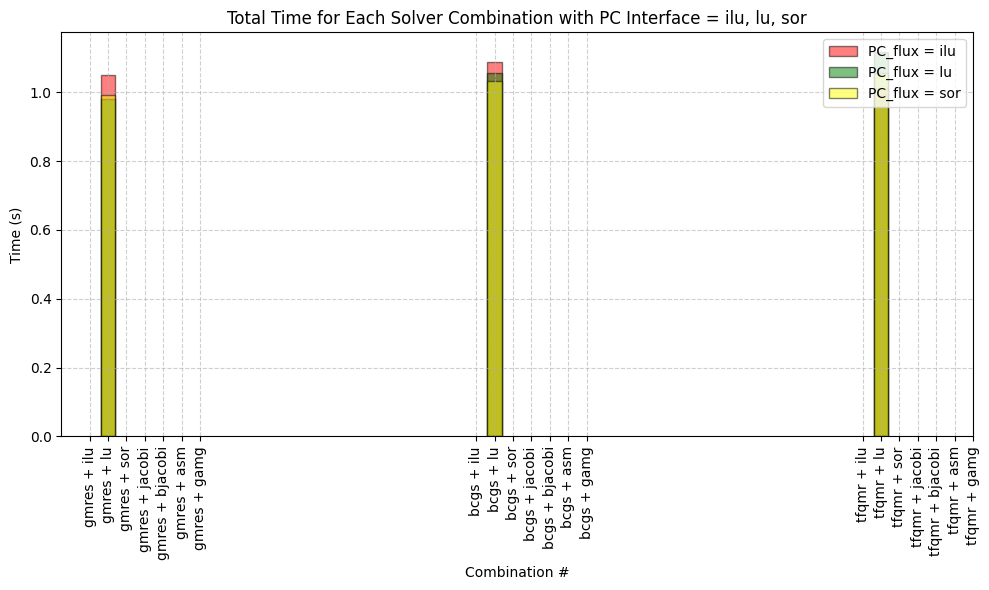

In [91]:
# Filter to combinations where PC Interface == 'ilu', etc. (if several PC Interfaces are used) 
df_flux_ilu = df_results[df_results["PC Interface"] == "ilu" ]
df_flux_lu = df_results[df_results["PC Interface"] == "lu"] 
df_flux_sor = df_results[df_results["PC Interface"] == "sor"] 

df_flux_ilu["label"] = df_flux_ilu["KSP Type"] + " + " + df_flux_ilu["PC Mass"]


# Plot Total Time for each combination
plt.figure(figsize=(10, 6))
plt.bar(df_flux_ilu["Combination #"], df_flux_ilu["Total Time (s)"], color="red", edgecolor="k",alpha=0.5, label='PC_flux = ilu' )
plt.bar(df_flux_ilu["Combination #"], df_flux_lu["Total Time (s)"], color="green", edgecolor="k", alpha=0.5, label='PC_flux = lu')
plt.bar(df_flux_ilu["Combination #"], df_flux_sor["Total Time (s)"], color="yellow", edgecolor="k", alpha=0.5, label='PC_flux = sor')
plt.xlabel("Combination #")
plt.ylabel("Time (s)")
plt.legend()
plt.title("Total Time for Each Solver Combination with PC Interface = ilu, lu, sor")
#plt.xticks(df_flux_ilu["Combination #"], rotation=90)
plt.xticks(ticks=df_flux_ilu["Combination #"], labels=df_flux_ilu["label"], rotation=90)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



/tmp/ipykernel_80742/1986493755.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flux_ilu["label"] = df_flux_ilu["KSP Type"] + " + " + df_flux_ilu["PC Mass"]


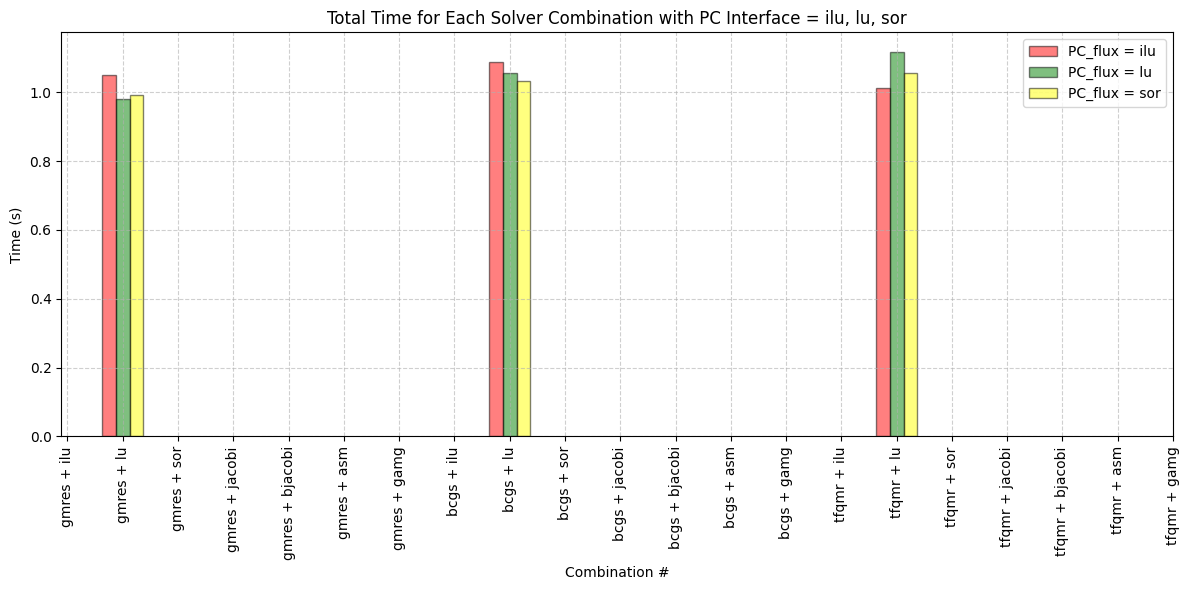

In [92]:

# Filter by PC Interface
df_flux_ilu = df_results[df_results["PC Interface"] == "ilu"]
df_flux_lu = df_results[df_results["PC Interface"] == "lu"]
df_flux_sor = df_results[df_results["PC Interface"] == "sor"]

df_flux_ilu["label"] = df_flux_ilu["KSP Type"] + " + " + df_flux_ilu["PC Mass"]

# Shared x axis values
x = np.arange(len(df_flux_ilu))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, df_flux_ilu["Total Time (s)"], width=bar_width, color="red", edgecolor="k", alpha=0.5, label="PC_flux = ilu")
plt.bar(x, df_flux_lu["Total Time (s)"], width=bar_width, color="green", edgecolor="k", alpha=0.5, label="PC_flux = lu")
plt.bar(x + bar_width, df_flux_sor["Total Time (s)"], width=bar_width, color="yellow", edgecolor="k", alpha=0.5, label="PC_flux = sor")

plt.xlabel("Combination #")
plt.ylabel("Time (s)")
plt.title("Total Time for Each Solver Combination with PC Interface = ilu, lu, sor")
plt.xticks(ticks=x, labels=df_flux_ilu["label"], rotation=90)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
df_flux_ilu



### Testing Total Time distribution

In [38]:
linear_solver_opts = {
    # This line PETSc print the residual norm at each iteration.
    #"ksp_monitor": None,
    #"ksp_view": None,
    "ksp_type": 'bcgs',#"preonly",#"tfqmr1",#"gmres1", #"richardson0", #"bicg0", #"bcgs1",  # Change the Krylov method
    "ksp_max_it": 150,
    "interface_darcy_flux": {"pc_type": "ilu"}, # fix this to ilu for now
    "mass_balance": {"pc_type": "gamg"},
}

model.params["linear_solver"].update({"options": linear_solver_opts})
reset_model_state(model)
print(model.params["linear_solver"].get("options", {}))

{'ksp_type': 'bcgs', 'ksp_max_it': 150, 'interface_darcy_flux': {'pc_type': 'ilu'}, 'mass_balance': {'pc_type': 'gamg'}}


In [ ]:
model._krylov_iters, model._solve_time, model._construction_time=[],[],[]

# Store results
results = []
N_MC = 1000 # Number of Monte Carlo runs

print(linear_solver_opts)
print(f"Running MC simulation with {N_MC} interations")
for i in range(N_MC):
    
    reset_model_state(model)
        
      
    try:
        print(f"Iteration {i+1}/{N_MC}...")
        start = time.time()
        pp.run_time_dependent_model(model, {"prepare_simulation": False})
        end = time.time()

        results.append({
            "Krylov Iters": model._krylov_iters[-1],
            "Construction Time (s)": model._construction_time[-1],
            "Solve Time (s)": model._solve_time[-1],
            "Total Time (s)": model._construction_time[-1] + model._solve_time[-1],
            "Tic Toc Time (s)": end - start
            })
      
    except Exception as e:
        print(f"   ⚠️ Error: {type(e).__name__}: {e}")
        # print(f" Error: {e}")
       
# Convert results to DataFrame and save
df_MC = pd.DataFrame(results)
df_MC.head()


{'ksp_type': 'bcgs', 'ksp_max_it': 150, 'interface_darcy_flux': {'pc_type': 'ilu'}, 'mass_balance': {'pc_type': 'gamg'}}
Running MC simulation with 1000 interations
Iteration 1/1000...
Iteration 2/1000...
Iteration 3/1000...
Iteration 4/1000...
Iteration 5/1000...
Iteration 6/1000...
Iteration 7/1000...
Iteration 8/1000...
Iteration 9/1000...
Iteration 10/1000...
Iteration 11/1000...
Iteration 12/1000...
Iteration 13/1000...
Iteration 14/1000...
Iteration 15/1000...
Iteration 16/1000...
Iteration 17/1000...
Iteration 18/1000...
Iteration 19/1000...
Iteration 20/1000...
Iteration 21/1000...
Iteration 22/1000...
Iteration 23/1000...
Iteration 24/1000...
Iteration 25/1000...
Iteration 26/1000...
Iteration 27/1000...
Iteration 28/1000...
Iteration 29/1000...
Iteration 30/1000...
Iteration 31/1000...
Iteration 32/1000...
Iteration 33/1000...
Iteration 34/1000...
Iteration 35/1000...
Iteration 36/1000...
Iteration 37/1000...
Iteration 38/1000...
Iteration 39/1000...
Iteration 40/1000...
Iter

,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s)
0,67,0.101434,0.387320,0.488754,3.859936
1,67,0.115587,0.448033,0.563620,4.004017
2,67,0.107068,0.415264,0.522332,3.872015
3,67,0.150098,0.408878,0.558976,3.894114
4,67,0.099847,0.391865,0.491712,3.815107


In [65]:
df_MC.to_csv("/host_output/Data/OneSolver_Distr_MC.csv", index=False)

In [49]:
print(linear_solver_opts)

{'ksp_type': 'bcgs', 'ksp_max_it': 150, 'interface_darcy_flux': {'pc_type': 'ilu'}, 'mass_balance': {'pc_type': 'gamg'}}


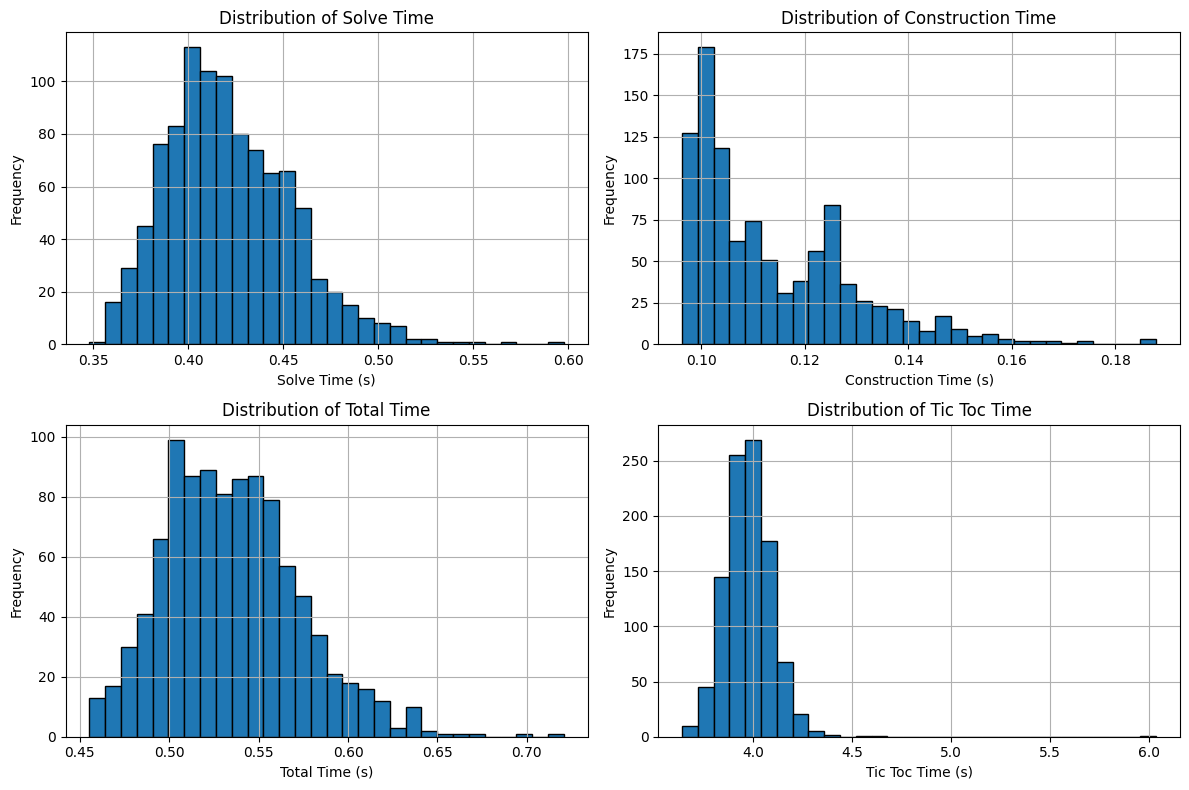

In [60]:
# Plotting the distributions of the results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Flatten to index easily

columns = ['Solve Time (s)', 'Construction Time (s)', 'Total Time (s)', 'Tic Toc Time (s)']
titles = ['Distribution of Solve Time', 
          'Distribution of Construction Time', 
          'Distribution of Total Time', 
          'Distribution of Tic Toc Time']

for i in range(4):
    axes[i].hist(df_MC[columns[i]], bins=30, edgecolor='black')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(columns[i])
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


### MC in parallell

In [61]:
model._krylov_iters, model._solve_time, model._construction_time=[],[],[]

import copy
from concurrent.futures import ProcessPoolExecutor, as_completed


def run_single_simulation(i):
    local_model = copy.deepcopy(model)  # ensure thread safety
    reset_model_state(local_model)

    try:
        start = time.time()
        pp.run_time_dependent_model(local_model, {"prepare_simulation": False})
        end = time.time()

        return {
            "Krylov Iters": local_model._krylov_iters[-1],
            "Construction Time (s)": local_model._construction_time[-1],
            "Solve Time (s)": local_model._solve_time[-1],
            "Total Time (s)": local_model._construction_time[-1] + local_model._solve_time[-1],
            "Tic Toc Time (s)": end - start
        }

    except Exception as e:
        return {"error": f"{type(e).__name__}: {str(e)}"}

# Parallel execution
results = []

# Recommend using 8 workers for your 8 physical cores
with ProcessPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(run_single_simulation, i): i for i in range(N_MC)}

    for future in as_completed(futures):
        result = future.result()
        idx = futures[future]
        if "error" in result:
            print(f"⚠️ Iteration {idx + 1} failed: {result['error']}")
        else:
            print(f"✓ Iteration {idx + 1} completed.")
            results.append(result)

# Create DataFrame
df_MCp = pd.DataFrame(results)
df_MCp.head()


✓ Iteration 3 completed.
✓ Iteration 5 completed.
✓ Iteration 1 completed.
✓ Iteration 4 completed.
✓ Iteration 6 completed.
✓ Iteration 8 completed.
✓ Iteration 2 completed.
✓ Iteration 7 completed.
✓ Iteration 9 completed.
✓ Iteration 11 completed.
✓ Iteration 14 completed.
✓ Iteration 12 completed.
✓ Iteration 10 completed.
✓ Iteration 13 completed.
✓ Iteration 16 completed.
✓ Iteration 15 completed.
✓ Iteration 17 completed.
✓ Iteration 18 completed.
✓ Iteration 19 completed.
✓ Iteration 21 completed.
✓ Iteration 22 completed.
✓ Iteration 20 completed.
✓ Iteration 23 completed.
✓ Iteration 24 completed.
✓ Iteration 25 completed.
✓ Iteration 29 completed.
✓ Iteration 28 completed.
✓ Iteration 27 completed.
✓ Iteration 30 completed.
✓ Iteration 26 completed.
✓ Iteration 32 completed.
✓ Iteration 31 completed.
✓ Iteration 35 completed.
✓ Iteration 34 completed.
✓ Iteration 33 completed.
✓ Iteration 37 completed.
✓ Iteration 36 completed.
✓ Iteration 38 completed.
✓ Iteration 40 comple

,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s)
0,67,0.144806,0.579773,0.724579,5.102841
1,67,0.134468,0.609905,0.744374,5.119369
2,67,0.134932,0.616567,0.751499,5.314639
3,67,0.128206,0.612728,0.740934,5.314445
4,67,0.134568,0.584562,0.719131,5.334439


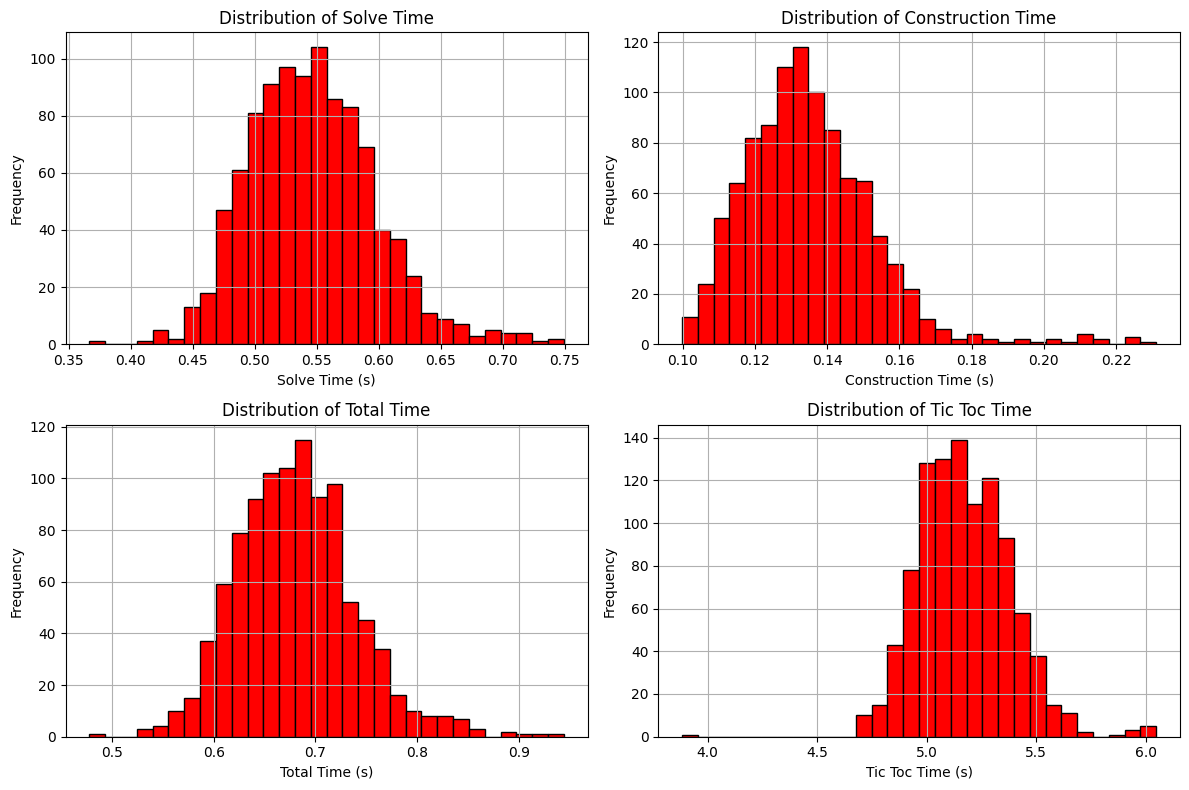

In [62]:
# Plotting the distributions of the results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Flatten to index easily

columns = ['Solve Time (s)', 'Construction Time (s)', 'Total Time (s)', 'Tic Toc Time (s)']
titles = ['Distribution of Solve Time', 
          'Distribution of Construction Time', 
          'Distribution of Total Time', 
          'Distribution of Tic Toc Time']

for i in range(4):
    axes[i].hist(df_MCp[columns[i]], bins=30, color = 'red', edgecolor='black')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(columns[i])
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [66]:
df_MCp.to_csv("/host_output/Data/OneSolver_Distr_MC_parallell.csv", index=False)

In [ ]:
model.mdg.subdomains

<bound method MixedDimensionalGrid.subdomains of Mixed-dimensional grid containing 225 grids and 398 interfaces.
Maximum dimension present: 2 
Minimum dimension present: 0 
1 grids of dimension 2 with in total 16657 cells
50 grids of dimension 1 with in total 2041 cells
174 grids of dimension 0 with in total 174 cells
50 interfaces between grids of dimension 2 and 1 with in total 4082 mortar cells.
348 interfaces between grids of dimension 1 and 0 with in total 696 mortar cells.
>

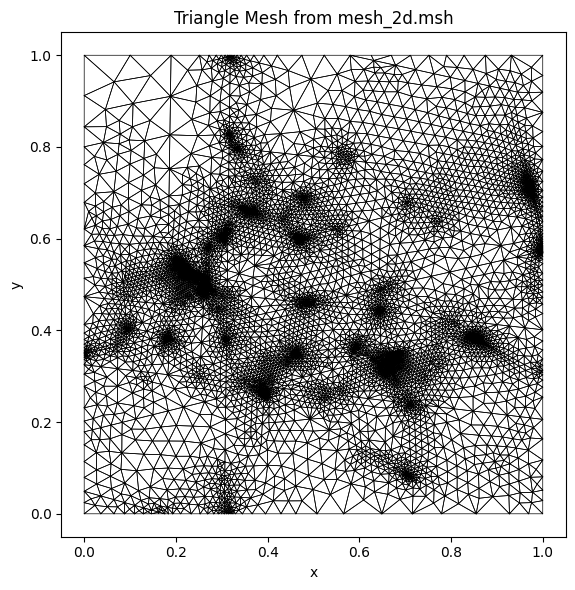

In [69]:
import meshio
# Load the mesh
mesh = meshio.read("mesh_2d.msh")

# Extract 2D points and triangle connectivity
points = mesh.points[:, :2]  # only x and y
triangles = mesh.cells_dict.get("triangle")

if triangles is None:
    raise ValueError("No triangle elements found in the mesh.")

# Plot
plt.figure(figsize=(8, 6))
for tri in triangles:
    tri_coords = points[tri]
    tri_coords = np.vstack([tri_coords, tri_coords[0]])  # close the triangle
    plt.plot(tri_coords[:, 0], tri_coords[:, 1], color='black', linewidth=0.5)

plt.gca().set_aspect("equal")
plt.title("Triangle Mesh from mesh_2d.msh")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


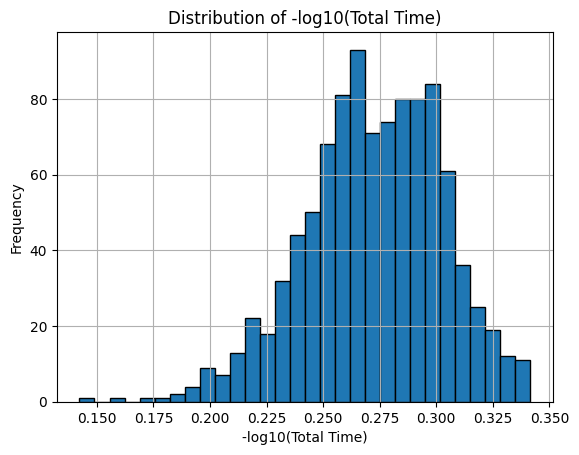

In [67]:

# Apply -log10 transformation
log_time = -np.log10(df_MC['Total Time (s)'])

# Plot histogram
plt.hist(log_time, bins=30, edgecolor='black')
plt.title("Distribution of -log10(Total Time)")
plt.xlabel("-log10(Total Time)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
  

In [94]:
from functools import partial


# Limit number of threads for numerical libraries
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

# Clear previous stats
model._krylov_iters, model._solve_time, model._construction_time = [], [], []

# --- Simulation function ---
def run_single_simulation(base_model, i):
    local_model = copy.deepcopy(base_model)
    reset_model_state(local_model)

    try:
        start = time.time()
        pp.run_time_dependent_model(local_model, {"prepare_simulation": False})
        end = time.time()

        return {
            "Krylov Iters": local_model._krylov_iters[-1],
            "Construction Time (s)": local_model._construction_time[-1],
            "Solve Time (s)": local_model._solve_time[-1],
            "Total Time (s)": local_model._construction_time[-1] + local_model._solve_time[-1],
            "Tic Toc Time (s)": end - start
        }

    except Exception as e:
        return {"error": f"{type(e).__name__}: {str(e)}"}

# --- Monte Carlo Parallel Execution ---
N_MC = 100
results = []
max_workers = 8  # Based on your 8 physical cores

start_all = time.time()

with ProcessPoolExecutor(max_workers=max_workers) as executor:
    run_func = partial(run_single_simulation, model)
    futures = {executor.submit(run_func, i): i for i in range(N_MC)}

    for future in as_completed(futures):

        result = future.result()
        idx = futures[future]
        if "error" in result:
            print(f"⚠️ Iteration {idx + 1} failed: {result['error']}")
        else:
            print(f"✓ Iteration {idx + 1} completed.")
            results.append(result)

end_all = time.time()
print(f"🔧 Total wall time for {N_MC} simulations: {end_all - start_all:.2f} seconds")

# Convert to DataFrame
df_MCp = pd.DataFrame(results)
df_MCp.head()


AttributeError: Can't get local object 'FluidDensityFromPressure.density_of_phase.<locals>.rho'